# PHYS 210 Mini-Project 04
### Maxwell Boltzmann Distribution
Due Wed, Nov 30, 2022 - 9am

In [87]:
# Main code and animation here
"""
This code will simulate the behaviour of a noble gas, modelling
the gas as a collection of particles with initial velocities
undergoing elastic collisions.
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from itertools import combinations
from IPython.display import HTML
import matplotlib

npoint = 400  # number of particles
nframe = 500  # number of frames in animation
xmin, xmax, ymin, ymax = 0, 1, 0, 1  # the bounds of the plot
Dt = 0.00002  # time step
pr = 0.0015  # particle radius
pm = 2.672 * 10**(-26)  # particle mass

x = np.random.random(npoint)  # the x position array of particles
y = np.random.random(npoint)  # the y position array of particles
vx = -500. * np.ones(npoint)  # initial x velocity array
vy = np.zeros(npoint)  # inital y velocity array
vx[x <= 0.5] = -vx[x <= 0.5]  # sets x velocities on left of screen to -500

# arrays used to trace back array indicies used in collisions
arr = np.arange(len(x))
pairs = np.asarray(list(combinations(arr, 2)))


def trace(pairindex):
    """Finds the index of the 2 individual values
    from the origional x array that were used to
    create a specific pair in the list of combinations.

    pairindex: the index of the pair which we want to
    trace back to its origional values in x.

    returns a list of the index of the 1st value and b
    the index of the 2nd value from x for the combination
    in xx.
    """

    a = pairs[pairindex][:, 0]  # finds first position index
    b = pairs[pairindex][:, 1]  # finds second position index
    return a, b


def update_point(num):
    """This function updates the particle position and simulates
    the collisions between particles, updating the frames to be
    animated every 2 simulation updates.

    num: a placeholder parameter for use in FuncAnimation()

    returns None"""

    global x, y, vx, vy  # reference global variables
    print('.', end='')  # Provide progress feedback
    for i in range(2):  # runs 2 iterations
        dx = Dt * vx  # calculates the change in x for the timestep Dt
        dy = Dt * vy  # calculates the change in y for the timestep Dt
        x = x + dx  # sets new x to x + dx
        y = y + dy  # sets new y to y + dy
        indx = np.where(
            (x < xmin) | (x > xmax))  # finds x values out of bounds
        indy = np.where(
            (y < ymin) | (y > ymax))  # finds y values out of bounds
        # reverses velocity of out of bounds particles
        vx[indx] = -vx[indx]
        vy[indy] = -vy[indy]

        xx = np.asarray(list(combinations(x, 2)))  # pairs of x values
        yy = np.asarray(list(combinations(y, 2)))  # paris of y values
        # Distances between particles:
        dd = (xx[:, 0] - xx[:, 1])**2 + (yy[:, 0] - yy[:, 1])**2
        # finds index of dd where distance between particles are smaller
        # than 2x the particle radius
        col = np.where(np.sqrt(dd) <= 2 * pr)

        p1, p2 = trace(
            col
        )  # finds index of 1st and 2nd values that make up xx and yy pairs
        # converts p1 and p2 to list
        p1 = list(p1)
        p2 = list(p2)

        ovx = np.copy(vx)  # make a copy of vx for array operations
        ovy = np.copy(vy)  # make a copy of vy for array operations
        ox = np.copy(x)  # make a copy of x for array operations
        oy = np.copy(y)  # make a copy of y for array operations
        # calculates new vx for the 1st particle in collision
        vx[p1] = ovx[p1] - ((ovx[p1] - ovx[p2]) * (ox[p1] - ox[p2]) +
                            (ovy[p1] - ovy[p2]) *
                            (oy[p1] - oy[p2])) * (ox[p1] - ox[p2]) / dd[col]
        # calculates new vx for the 2nd particle in collision
        vx[p2] = ovx[p2] - ((ovx[p2] - ovx[p1]) * (ox[p2] - ox[p1]) +
                            (ovy[p2] - ovy[p1]) *
                            (oy[p2] - oy[p1])) * (ox[p2] - ox[p1]) / dd[col]
        # calculates new vy for the 1st particle in collision
        vy[p1] = ovy[p1] - ((ovx[p1] - ovx[p2]) * (ox[p1] - ox[p2]) +
                            (ovy[p1] - ovy[p2]) *
                            (oy[p1] - oy[p2])) * (oy[p1] - oy[p2]) / dd[col]
        # calculates new vy for the 2nd particle in collision
        vy[p2] = ovy[p2] - ((ovx[p2] - ovx[p1]) * (ox[p2] - ox[p1]) +
                            (ovy[p2] - ovy[p1]) *
                            (oy[p2] - oy[p1])) * (oy[p2] - oy[p1]) / dd[col]

    data = np.stack((x, y), axis=-1)  # stacks x and y arrays
    im.set_offsets(data)  # sets offets for data array


fig, ax = plt.subplots()  # max plot figure and axis
# sets limits of plot
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# creates colour array for particles
carr = np.full(shape=(len(x), 3), fill_value=(0, 0, 0))
carr[x <= 0.5] = (0, 0, 1)
carr[x > 0.5] = (1, 0, 0)

# plots the particles as a scatter plot coloured as the colour array
im = ax.scatter(x, y, c=carr)
im.set_sizes([20])  # sets size of particles in animation

# creates animation using FuncAnimtion()
anim = animation.FuncAnimation(fig,
                               update_point,
                               nframe,
                               interval=40,
                               repeat=False)
# saves animation
anim.save('collide.webm', extra_args=['-vcodec', 'libvpx'])
plt.close()  # prevents stray plot from appearing
# displays animation in notebook
HTML('<video controls> <source src="collide.webm" ' +
     'type="video/webm"></video>')

.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

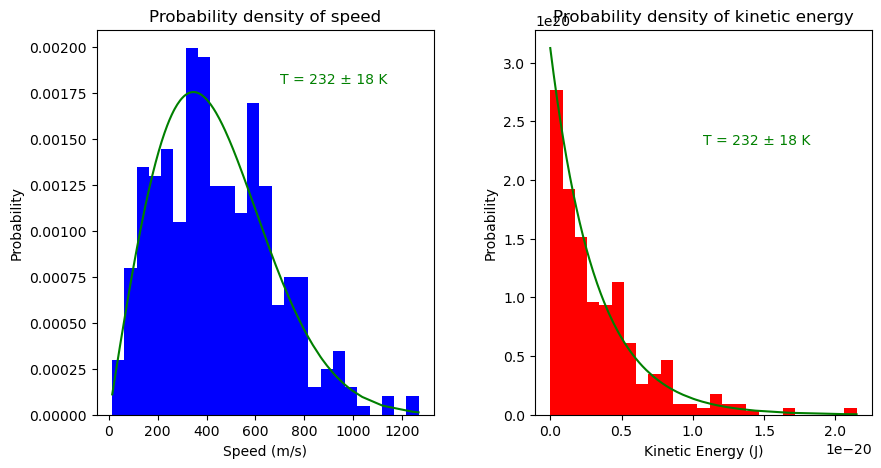

In [88]:
# Plots, fits and temperature output line here
"""This code creates histograms of the speed and kinetic energy of all
particles in simulation fits the temperature paramater to theoretical
functions and prduces plots of both the theoretical functions and the
histograms."""

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sci

v = np.sqrt(vx ** 2 + vy ** 2)  # calculates speed of all particles
Ek = 1 / 2 * pm * v ** 2  # calculates kinetic energy of all particles
kb = 1.38E-23  # Boltzman's constant

vhist = np.histogram(v, 25, density=True)  # makes velocity histogram
Ehist = np.histogram(Ek, 25, density=True)  # makes kinetic energy histogram

fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # makes plot figure and axis
ax[0].hist(v, 25, density=True, color="blue")  # plots histogram of speed
ax[0].title.set_text(
    "Probability density of speed")  # sets title of speed histogram
# sets axis labels for velocity histogram
ax[0].xaxis.label.set_text("Speed (m/s)")
ax[0].yaxis.label.set_text("Probability")
ax[1].hist(Ek, 25, density=True,
           color="red")  # plots histogram of kinetic energy
ax[1].title.set_text("Probability density of kinetic energy"
                     )  # sets title of kinetic energy histogram
# sets axis labels for kinetic energy histogram
ax[1].xaxis.label.set_text("Kinetic Energy (J)")
ax[1].yaxis.label.set_text("Probability")
plt.subplots_adjust(wspace=0.3)  # increases spacing between plots


def f(v, T):
    """Defines equation for Maxwell-Boltzmann distribution
    for a given velocity and temperature.

    v: speed of particles
    T: temperature of system

    returns the value of the Maxwell-Boltzmann distribution"""
    return pm * v / (T * kb) * np.exp(-pm * v ** 2 / (2 * kb * T))


def g(E, T):
    """Defines equation for Boltzmann distribution
    for a given velocity and temperature.

    v: speed of particles
    T: temperature of system

    returns the value of the Boltzmann distribution"""
    return 1 / (T * kb) * np.exp(-E / (kb * T))


# separates x and y arrays from histogram
vhistx = vhist[1][:-1]
vhisty = vhist[0]

guess = 220  # initial guess
# returns the fitted temperature value and the covarience
# of the fitted parameter
T, tcov = sci.curve_fit(f, vhistx, vhisty, p0=guess)
# calculates the uncertainty in the temperature
terr = np.sqrt(np.diag(tcov))

v.sort()  # sorts the speed array by size
Ek.sort()  # sorts the kinetic energy array by size

# plots Maxwell-Boltzmann distribution vs speed
ax[0].plot(v, f(v, T), color='green')
# plots Boltzmann distribution vs speed
ax[1].plot(Ek, g(Ek, T), color='green')
# displays temperature on the plots
ax[0].text(700,
           0.0018,
           "T = {:.0f} \u00B1 {:.0f} K".format(T[0], terr[0]),
           color='green')
ax[1].text(np.max(Ehist[1]) / 2,
           np.max(Ehist[0]) / 1.2,
           "T = {:.0f} \u00B1 {:.0f} K".format(T[0], terr[0]),
           color='green')
plt.show()  # shows plot

# Acknowledgements

In the cell below, please describe the role of **anyone other than yourself** who contributed to the work shown in this notebook.

Its ok to get help from us and classmates! Please get in the habit of acknowledging such contributions.

If you want to refer to a classmate, please use only their cocalc email-id and not their name - or you could just say something like: "a classmate gave me the idea to use xxx feature to solve yyy problem."


_Acknowledgements here:_



# Extension Code and Description
All solution code for the main project question should appear in the two main cells above above. Project extensions go in the cell "cell-extension" immediately below and the descriptions of your extension go in the cell below that.

In [89]:
# Main code and animation here
"""
This code is a "semi-simulation" of gaseous charged particles.
It works practically the same as the main project, but the
blue and red particles are oppositely charged. The electro-
static force has been amplified for demonstration, and when
the particles collide they can sometimes "annihilate" as
the attractive force often overcomes the code for particle
collision and the distance between the particles becomes far
too small and the velocity kind of goes haywire and the 2
particles appear to dissapear.
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from itertools import combinations, permutations
from IPython.display import HTML
import matplotlib

npoint = 150
nframe = 300
xmin, xmax, ymin, ymax = 0, 1, 0, 1
Dt = 0.00002  # time step
pr = 0.0015  # particle radius
pm = 1.674E-27  # particle mass
charge = 1.602E-19
ke = 8.988E9

x = np.random.random(npoint)
y = np.random.random(npoint)
vx = -400. * np.ones(npoint)
vy = np.zeros(npoint)
vx[x <= 0.5] = -vx[x <= 0.5]

chargearr = np.full(npoint, charge)
chargearr[x >= 0.5] *= -1

accx = np.zeros(npoint)
accy = np.zeros(npoint)

arr = np.arange(len(x))
pairs = np.asarray(list(combinations(arr, 2)))


def trace(pairindex):
    """Finds the index of the 2 individual values
    from the origional x array that were used to
    create a specific pair in the list of combinations.

    pairindex: the index of the pair which we want to
    trace back to its origional values in x.

    returns a list of the index of the 1st value and b
    the index of the 2nd value from x for the combination
    in xx.
    """

    a = pairs[pairindex][:, 0]
    b = pairs[pairindex][:, 1]
    return a, b


def update_point(num):
    global x, y, vx, vy, accx, accy
    #print('.', end='')  # Provide progress feedback
    for i in range(2):
        dx = Dt * vx + 1 / 2 * Dt**2 * accx
        dy = Dt * vy + 1 / 2 * Dt**2 * accy
        x = x + dx
        y = y + dy
        indx = np.where((x < xmin) | (x > xmax))
        indy = np.where((y < ymin) | (y > ymax))
        vx[indx] = -vx[indx]
        vy[indy] = -vy[indy]

        xx = np.asarray(list(combinations(x, 2)))
        yy = np.asarray(list(combinations(y, 2)))
        cc = np.asarray(list(permutations(chargearr, 2)))
        xxc = np.asarray(list(permutations(x, 2)))
        yyc = np.asarray(list(permutations(y, 2)))
        # Distances between particles (squared):
        dd = (xx[:, 0] - xx[:, 1])**2 + (yy[:, 0] - yy[:, 1])**2
        ddc = (xxc[:, 0] - xxc[:, 1])**2 + (yyc[:, 0] - yyc[:, 1])**2

        ffx = ke * cc[:, 0] * cc[:, 1] / ddc**(3 / 2) * (xxc[:, 0] -
                                                         xxc[:, 1]) * 6E4
        ffy = ke * cc[:, 0] * cc[:, 1] / ddc**(3 / 2) * (yyc[:, 0] -
                                                         yyc[:, 1]) * 6E4

        for i in range(npoint):
            accx[i] = np.sum(ffx[i * (npoint - 1):i * (npoint - 1) +
                                 (npoint - 1)]) / pm
            accy[i] = np.sum(ffy[i * (npoint - 1):i * (npoint - 1) +
                                 (npoint - 1)]) / pm

        col = np.where(np.sqrt(dd) <= 2 * pr)

        p1, p2 = trace(col)
        p1 = list(p1)
        p2 = list(p2)

        ovx = np.copy(vx)
        ovy = np.copy(vy)
        ox = np.copy(x)
        oy = np.copy(y)
        vx[p1] = ovx[p1] - ((ovx[p1] - ovx[p2]) * (ox[p1] - ox[p2]) +
                            (ovy[p1] - ovy[p2]) *
                            (oy[p1] - oy[p2])) * (ox[p1] - ox[p2]) / dd[col]
        vx[p2] = ovx[p2] - ((ovx[p2] - ovx[p1]) * (ox[p2] - ox[p1]) +
                            (ovy[p2] - ovy[p1]) *
                            (oy[p2] - oy[p1])) * (ox[p2] - ox[p1]) / dd[col]
        vy[p1] = ovy[p1] - ((ovx[p1] - ovx[p2]) * (ox[p1] - ox[p2]) +
                            (ovy[p1] - ovy[p2]) *
                            (oy[p1] - oy[p2])) * (oy[p1] - oy[p2]) / dd[col]
        vy[p2] = ovy[p2] - ((ovx[p2] - ovx[p1]) * (ox[p2] - ox[p1]) +
                            (ovy[p2] - ovy[p1]) *
                            (oy[p2] - oy[p1])) * (oy[p2] - oy[p1]) / dd[col]

    data = np.stack((x, y), axis=-1)
    im.set_offsets(data)


fig, ax = plt.subplots()
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

carr = np.full(shape=(len(x), 3), fill_value=(0, 0, 0))
carr[x <= 0.5] = (0, 0, 1)
carr[x > 0.5] = (1, 0, 0)

im = ax.scatter(x, y, c=carr)
im.set_sizes([20])

anim = animation.FuncAnimation(fig,
                               update_point,
                               nframe,
                               interval=40,
                               repeat=False)
anim.save('collide_ext.webm', extra_args=['-vcodec', 'libvpx'])
plt.close()
HTML('<video controls> <source src="collide_ext.webm" ' +
     'type="video/webm"></video>')

_In this cell, please describe any new language features or project extension you have implemented:_




# Grading cells
The cells below marked as "grade use only" are created as placeholders so that we can provide a manual grade and comments for each category. 

Exceptions are the "2. Style" test, which has an associated autograder test that you can run to check style and the timing cell "cell-optimization0", which you can use to test your code execution time.

In [90]:
# 1. Code execution (grader use only)

In [91]:
# 2. Style: pep8 (see note below regarding use of the Format button to fix many errors)
#
# Tests for pep8 returns warnings or errors. You may need to hit 'Save' after making changes for them to take effect.
nb_name = "project04.ipynb"
cells_to_check = []
stop_at = ['cell-extension']
# check_style2.py uses cells_to_check and nb_name
%run -i check_style2.py

checking cell: cell-project4-1
checking cell: cell-project4-2
Style errors or warnings found:
61:29: W291 trailing whitespace


AssertionError: 

Also note that you can use the Format button while in a code cell to automagically fix most pep8 errors (other than way too long print statements)

![](project02-format.png)

In [ ]:
# 3. Results (grader use only)

In [ ]:
# 4. Readability (grader use only)

In [ ]:
# 5. Plot (grader use only)

.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Time for cell: cell-project4-1 time: 89.14


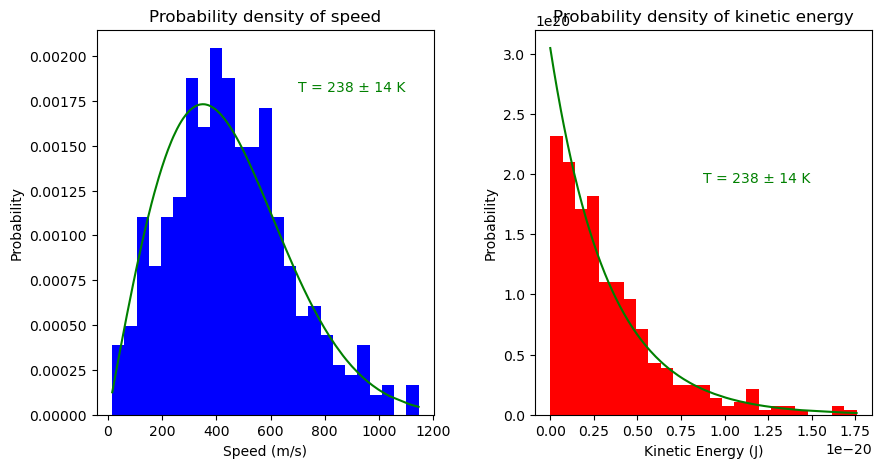

Time for cell: cell-project4-2 time: 0.20
Total time: 89.34


In [ ]:
# Check execution time
nb_name = "project04.ipynb"
cells_to_time = []
stop_at = ['cell-extension']
%run -i time_cells2.py

In [ ]:
# 5. Code optimization/timing (grader use only)

In [ ]:
# B2. New Functionality/Language features (grader use only)